In [104]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from numpy import nan
import pandas as pd

import pickle
import collections
from collections import defaultdict 

from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import seaborn as sns
import re

import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
from lofo import LOFOImportance, Dataset, plot_importance
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, recall_score, precision_score, matthews_corrcoef
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import ExtraTreeClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.svm import SVC
import pickle

In [2]:
# Convert field names to dict for easy access.
# Can be hard coded 

fields_path = '../data/training_validation_2/fields.csv'  
fields_df = pd.read_csv(fields_path)
fields_df.columns = ['name', 'f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6']

fields_dict = {}

for idx in range(fields_df.shape[0]):
    name = fields_df.loc[idx, 'name']

    _fields = []
    
    for f in fields_df.columns[1:]:
        if not (str(fields_df.loc[idx, f]) == 'nan'):
            _fields.append(name + "_" + str(fields_df.loc[idx, f]))
    
    fields_dict[idx] = {'name': fields_df.loc[idx, 'name'] , 'fields': _fields}

fields_dict

{0: {'name': 'CpuTemperature',
  'fields': ['CpuTemperature_vMax',
   'CpuTemperature_vMin',
   'CpuTemperature_vStd',
   'CpuTemperature_value']},
 1: {'name': 'DurationPickToPick',
  'fields': ['DurationPickToPick_vCnt',
   'DurationPickToPick_vFreq',
   'DurationPickToPick_vMax',
   'DurationPickToPick_vMin',
   'DurationPickToPick_vStd',
   'DurationPickToPick_vTrend',
   'DurationPickToPick_value']},
 2: {'name': 'DurationRobotFromFeederToTestBench',
  'fields': ['DurationRobotFromFeederToTestBench_vCnt',
   'DurationRobotFromFeederToTestBench_vFreq',
   'DurationRobotFromFeederToTestBench_vMax',
   'DurationRobotFromFeederToTestBench_vMin',
   'DurationRobotFromFeederToTestBench_vStd',
   'DurationRobotFromFeederToTestBench_vTrend',
   'DurationRobotFromFeederToTestBench_value']},
 3: {'name': 'DurationRobotFromTestBenchToFeeder',
  'fields': ['DurationRobotFromTestBenchToFeeder_vCnt',
   'DurationRobotFromTestBenchToFeeder_vFreq',
   'DurationRobotFromTestBenchToFeeder_vMax',
  

In [4]:
# Get class id and run id from filename
def parse_class_name(fname):
    p = re.compile("^class[^\d]*(\d+)_(\d+).*.csv")
    m = p.match(fname)
    
    return m.groups()

In [5]:
# Load one data file and return in a data frame
def load_data_file(path, fname):
    fullpath = join(path,fname)
    df = pd.read_csv(fullpath)
    df.columns = ['name', 'data']
    
    dfx = []
    
    for f in fields_dict:
        name = fields_dict[f]['name']
        fields = fields_dict[f]['fields']
        
        data = eval(df.loc[f,'data']) # convert data to array
        
        new_df = pd.DataFrame(data)
        if (f==33) and (new_df.shape[1] == 6): # NumberFuseDetected has a special case!
            new_df[6] = new_df[5]
            new_df[5] = np.NaN
            

        new_df.columns = fields_dict[f]['fields']
        
        dfx.append(new_df)
        
    merged_df = pd.concat(dfx, axis=1) # Merge columns
    
    c, r = parse_class_name(fname) # Get class id and run id

    # Add class labels and run id
    merged_df['class'] = int(c)
    merged_df['run'] = int(r)

    return merged_df

In [6]:
# Load data files from a directory and return merged data frame
def load_data_files(path):
    
    print ("In", path)
    files = [] 
    for f in listdir(path):
        if (isfile(join(path, f)) and (f.startswith("class"))):
            files.append(f)
    
    data_df_list = []
    for fname in files:
        print ("Loading:", fname)
        
        df = load_data_file(path, fname)
        
        data_df_list.append(df)

    data_df = pd.concat(data_df_list, axis=0) # Merge data frames
    
    return data_df

In [8]:
%%time
data_df_1 = load_data_files("../data/training_validation_1/")
data_df_2 = load_data_files("../data/training_validation_2/")
data_df_3 = load_data_files("../data/ModelRefinement/")

In ../data/training_validation_1/
Loading: class_ 0_0_data.csv
Loading: class_ 0_11_data.csv
Loading: class_ 0_17_data.csv
Loading: class_ 0_18_data.csv
Loading: class_ 0_19_data.csv
Loading: class_ 0_1_data.csv
Loading: class_ 0_20_data.csv
Loading: class_ 0_23_data.csv
Loading: class_ 0_25_data.csv
Loading: class_ 0_27_data.csv
Loading: class_ 0_29_data.csv
Loading: class_ 0_31_data.csv
Loading: class_ 0_32_data.csv
Loading: class_ 0_35_data.csv
Loading: class_ 0_36_data.csv
Loading: class_ 0_37_data.csv
Loading: class_ 0_38_data.csv
Loading: class_ 0_41_data.csv
Loading: class_ 0_43_data.csv
Loading: class_ 0_45_data.csv
Loading: class_ 0_46_data.csv
Loading: class_ 0_47_data.csv
Loading: class_ 0_53_data.csv
Loading: class_ 0_54_data.csv
Loading: class_ 0_55_data.csv
Loading: class_ 0_56_data.csv
Loading: class_ 0_57_data.csv
Loading: class_ 0_5_data.csv
Loading: class_ 0_60_data.csv
Loading: class_ 0_66_data.csv
Loading: class_ 0_67_data.csv
Loading: class_ 0_6_data.csv
Loading: c

In [10]:
data_df_1.to_csv("../data/training_validation_1.csv", index=False)
data_df_2.to_csv("../data/training_validation_2.csv", index=False)
data_df_3.to_csv("../data/model_refinement.csv", index=False)

In [13]:
data_df_1 = pd.read_csv("../data/training_validation_1.csv")
data_df_2 = pd.read_csv("../data/training_validation_2.csv")
data_df_3 = pd.read_csv("../data/model_refinement.csv")

In [23]:
data_df = pd.concat([data_df_1, data_df_2, data_df_3], axis=0, ignore_index=True)
data_df

,CpuTemperature_vMax,CpuTemperature_vMin,CpuTemperature_vStd,CpuTemperature_value,DurationPickToPick_vCnt,DurationPickToPick_vFreq,DurationPickToPick_vMax,DurationPickToPick_vMin,DurationPickToPick_vStd,DurationPickToPick_vTrend,...,VacuumValveClosed_vMin,VacuumValveClosed_vStd,VacuumValveClosed_vTrend,VacuumValveClosed_value,ValidFrame_vCnt,ValidFrame_vFreq,ValidFrameOptrisPIIRCamera_vCnt,ValidFrameOptrisPIIRCamera_vFreq,class,run
0,56.75,44.75,3.523729,47.833333,0.0,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,89.0,11.457455,259.0,27.582899,0,0
1,48.75,42.25,2.395308,45.000000,2.0,0.198207,3.192,2.807,0.192500,0.3850,...,-0.715812,0.112918,-0.013857,-0.580892,114.0,11.299041,273.0,27.058227,0,0
2,47.50,42.00,2.085815,43.825000,3.0,0.296778,3.230,3.106,0.051674,0.0200,...,-0.721671,0.109421,-0.008111,-0.596008,114.0,11.277551,272.0,26.907842,0,0
3,48.25,42.25,1.853375,45.200000,3.0,0.298541,3.307,3.103,0.085391,0.0310,...,-0.745598,0.116748,-0.002082,-0.595118,114.0,11.344572,271.0,26.968238,0,0
4,50.00,42.50,2.661766,45.700000,3.0,0.298554,3.242,3.153,0.038577,-0.0360,...,-0.720206,0.112639,-0.001516,-0.615755,113.0,11.245550,271.0,26.969415,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57966,62.00,55.00,1.920449,58.175000,4.0,0.398837,3.338,3.150,0.071434,-0.0326,...,-0.774895,0.114042,-0.006810,-0.660989,113.0,11.290777,270.0,26.977955,12,3
57967,61.75,56.00,1.902137,58.525000,2.0,0.199656,3.139,3.102,0.018500,-0.0370,...,-0.803217,0.136381,-0.010167,-0.671295,113.0,11.269392,270.0,26.926866,12,3
57968,61.75,55.25,2.064582,58.750000,3.0,0.299187,4.818,3.176,0.773340,-0.8210,...,-0.825190,0.128678,0.008731,-0.684622,114.0,11.366857,270.0,26.921505,12,3
57969,63.25,55.75,2.242271,57.833333,2.0,0.199835,3.375,3.263,0.056000,-0.1120,...,-0.764153,0.150226,0.061184,-0.660927,113.0,11.280370,270.0,26.953136,12,3


In [24]:
def get_nan_info_table(data, fields):

    field_df = data[fields]

    return field_df.isnull().sum().T

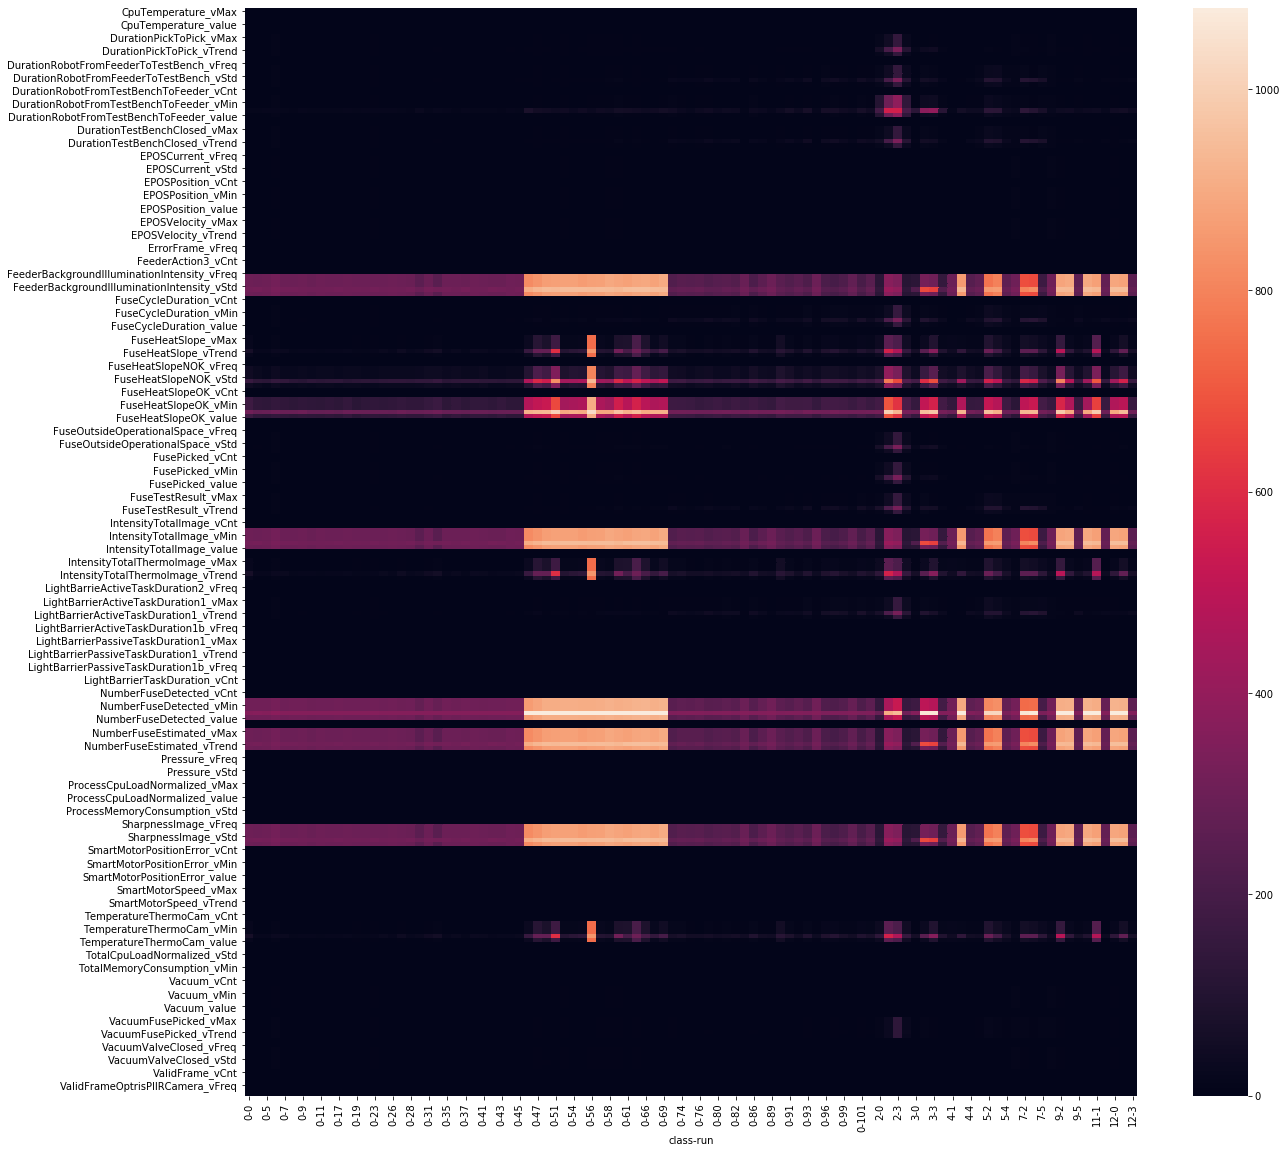

In [25]:
df = data_df.copy()
feature_sets = data_df.columns
nan_info_table = df.groupby(["class", "run"]).apply(get_nan_info_table, feature_sets)

plt.figure (figsize=(20, 20))
sns.heatmap(nan_info_table.T, annot=False)
plt.show()

In [26]:
droped_cols = []
first_cols = df.columns.tolist()

df = df.dropna(thresh=int(df.shape[0] * 0.7), axis=1)  # Drop column if it does not have at least x values that are **not** NaN
print("col: ", df.shape)
droped_cols.extend(list(set(first_cols).difference(df.columns)))

col:  (57971, 218)


In [27]:
def drop_nan_and_unique_data(df):
    
    for column in df.columns:
        if column not in ["class", "run"]:
            if (len(df[column].unique()) == 1) or (df[column].isnull().all()):
                df.drop(column, inplace=True, axis=1)
                droped_cols.append(column)
                print(column, "droped-unique")

            else:
                zero_rows = df.loc[df[column] == float(0)]
                if zero_rows.shape[0] >= df.shape[0] * 50:
                    df.drop(column, inplace=True, axis=1)
                    droped_cols.append(column)
                    print(column, "droped-zero")
    return df 

In [28]:
df = drop_nan_and_unique_data(df)

In [29]:
def fill_nan_values(data, name, fields):

    field_df = data[fields]

    if field_df.isnull().values.any():
        data[fields] = field_df.interpolate(method='linear', limit_direction='both')

    return data[fields]

In [30]:
for f in fields_dict:

    name = fields_dict[f]['name']
    fields = fields_dict[f]['fields']

    print("\nname:", name, "fields:", fields)
    fields = list(set(fields).difference(droped_cols))
    df_ = df.groupby(["class", "run"]).apply(fill_nan_values, name, fields)
    df_.reset_index(drop=True, inplace=True)
    df[fields] = df_[fields]


name: CpuTemperature fields: ['CpuTemperature_vMax', 'CpuTemperature_vMin', 'CpuTemperature_vStd', 'CpuTemperature_value']

name: DurationPickToPick fields: ['DurationPickToPick_vCnt', 'DurationPickToPick_vFreq', 'DurationPickToPick_vMax', 'DurationPickToPick_vMin', 'DurationPickToPick_vStd', 'DurationPickToPick_vTrend', 'DurationPickToPick_value']

name: DurationRobotFromFeederToTestBench fields: ['DurationRobotFromFeederToTestBench_vCnt', 'DurationRobotFromFeederToTestBench_vFreq', 'DurationRobotFromFeederToTestBench_vMax', 'DurationRobotFromFeederToTestBench_vMin', 'DurationRobotFromFeederToTestBench_vStd', 'DurationRobotFromFeederToTestBench_vTrend', 'DurationRobotFromFeederToTestBench_value']

name: DurationRobotFromTestBenchToFeeder fields: ['DurationRobotFromTestBenchToFeeder_vCnt', 'DurationRobotFromTestBenchToFeeder_vFreq', 'DurationRobotFromTestBenchToFeeder_vMax', 'DurationRobotFromTestBenchToFeeder_vMin', 'DurationRobotFromTestBenchToFeeder_vStd', 'DurationRobotFromTestBen


name: Vacuum fields: ['Vacuum_vCnt', 'Vacuum_vFreq', 'Vacuum_vMax', 'Vacuum_vMin', 'Vacuum_vStd', 'Vacuum_vTrend', 'Vacuum_value']

name: VacuumFusePicked fields: ['VacuumFusePicked_vCnt', 'VacuumFusePicked_vFreq', 'VacuumFusePicked_vMax', 'VacuumFusePicked_vMin', 'VacuumFusePicked_vStd', 'VacuumFusePicked_vTrend', 'VacuumFusePicked_value']

name: VacuumValveClosed fields: ['VacuumValveClosed_vCnt', 'VacuumValveClosed_vFreq', 'VacuumValveClosed_vMax', 'VacuumValveClosed_vMin', 'VacuumValveClosed_vStd', 'VacuumValveClosed_vTrend', 'VacuumValveClosed_value']

name: ValidFrame fields: ['ValidFrame_vCnt', 'ValidFrame_vFreq']

name: ValidFrameOptrisPIIRCamera fields: ['ValidFrameOptrisPIIRCamera_vCnt', 'ValidFrameOptrisPIIRCamera_vFreq']


In [31]:
print(df.isnull().sum().any())

False


In [32]:
df = drop_nan_and_unique_data(df)

FuseOutsideOperationalSpace_vMin droped-unique
LightBarrieActiveTaskDuration2_vCnt droped-unique
LightBarrieActiveTaskDuration2_vFreq droped-unique
LightBarrierActiveTaskDuration1b_vCnt droped-unique
LightBarrierActiveTaskDuration1b_vFreq droped-unique
LightBarrierPassiveTaskDuration1b_vCnt droped-unique
LightBarrierPassiveTaskDuration1b_vFreq droped-unique
LightBarrierPassiveTaskDuration2_vCnt droped-unique
LightBarrierPassiveTaskDuration2_vFreq droped-unique
LightBarrierTaskDuration_vCnt droped-unique
LightBarrierTaskDuration_vFreq droped-unique


In [33]:
df

,CpuTemperature_vMax,CpuTemperature_vMin,CpuTemperature_vStd,CpuTemperature_value,DurationPickToPick_vCnt,DurationPickToPick_vFreq,DurationPickToPick_vMax,DurationPickToPick_vMin,DurationPickToPick_vStd,DurationPickToPick_vTrend,...,VacuumValveClosed_vMin,VacuumValveClosed_vStd,VacuumValveClosed_vTrend,VacuumValveClosed_value,ValidFrame_vCnt,ValidFrame_vFreq,ValidFrameOptrisPIIRCamera_vCnt,ValidFrameOptrisPIIRCamera_vFreq,class,run
0,56.75,44.75,3.523729,47.833333,0.0,0.000000,3.192,2.807,0.192500,0.3850,...,-0.715812,0.112918,-0.013857,-0.580892,89.0,11.457455,259.0,27.582899,0,0
1,48.75,42.25,2.395308,45.000000,2.0,0.198207,3.192,2.807,0.192500,0.3850,...,-0.715812,0.112918,-0.013857,-0.580892,114.0,11.299041,273.0,27.058227,0,0
2,47.50,42.00,2.085815,43.825000,3.0,0.296778,3.230,3.106,0.051674,0.0200,...,-0.721671,0.109421,-0.008111,-0.596008,114.0,11.277551,272.0,26.907842,0,0
3,48.25,42.25,1.853375,45.200000,3.0,0.298541,3.307,3.103,0.085391,0.0310,...,-0.745598,0.116748,-0.002082,-0.595118,114.0,11.344572,271.0,26.968238,0,0
4,50.00,42.50,2.661766,45.700000,3.0,0.298554,3.242,3.153,0.038577,-0.0360,...,-0.720206,0.112639,-0.001516,-0.615755,113.0,11.245550,271.0,26.969415,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57966,62.00,55.00,1.920449,58.175000,4.0,0.398837,3.338,3.150,0.071434,-0.0326,...,-0.774895,0.114042,-0.006810,-0.660989,113.0,11.290777,270.0,26.977955,12,3
57967,61.75,56.00,1.902137,58.525000,2.0,0.199656,3.139,3.102,0.018500,-0.0370,...,-0.803217,0.136381,-0.010167,-0.671295,113.0,11.269392,270.0,26.926866,12,3
57968,61.75,55.25,2.064582,58.750000,3.0,0.299187,4.818,3.176,0.773340,-0.8210,...,-0.825190,0.128678,0.008731,-0.684622,114.0,11.366857,270.0,26.921505,12,3
57969,63.25,55.75,2.242271,57.833333,2.0,0.199835,3.375,3.263,0.056000,-0.1120,...,-0.764153,0.150226,0.061184,-0.660927,113.0,11.280370,270.0,26.953136,12,3


In [34]:
df.to_csv("../data/df_cleaned.csv", index=False)

In [48]:
data_df = pd.read_csv("../data/df_cleaned.csv")
df = data_df.copy()

In [38]:
# refinement_folds = {0: [100, 103, 10, 13, 26, 28, 42, 44, 49, 51, 58, 61, 64, 69, 73, 82, 89, 92, 94, 99],
#                     4: [1, 2, 4],
#                     11: [0, 1, 3],
#                     12: [0, 1, 3]
#                     }

# for key, value in refinement_folds.items():
#     df = df.loc[~((df["class"] == key) & df["run"].isin(value)

In [49]:
scaler_cols = list(set(df.columns).difference(["class", "run"]))

In [50]:
scaler = RobustScaler()
scaler_data = scaler.fit_transform(df[scaler_cols])
scaler_data = pd.DataFrame(scaler_data, index=df.index, columns=scaler_cols)
scaler_data

,EPOSVelocity_vFreq,ProcessMemoryConsumption_vMin,FeederAction2_vCnt,ErrorFrame_vFreq,LightBarrierActiveTaskDuration1_vMax,VacuumValveClosed_vMin,IntensityTotalThermoImage_vMin,FuseTestResult_value,CpuTemperature_vStd,LightBarrierActiveTaskDuration1_vMin,...,FuseHeatSlope_vCnt,EPOSPosition_vTrend,VacuumFusePicked_vCnt,DurationPickToPick_vCnt,VacuumFusePicked_vStd,DurationPickToPick_vMax,IntensityTotalImage_vFreq,FuseCycleDuration_vFreq,SmartMotorSpeed_vStd,NumberFuseEstimated_vCnt
0,-72.767123,-1.341659,0.0,0.0,10.666667,1.131148,-1.456011,0.000,1.574515,0.5,...,-2.0,1.055787,-5.875,-3.0,-0.322084,-0.291139,0.000000,-199.898109,0.0,0.0
1,-0.784342,-0.807454,1.0,0.0,10.666667,1.131148,-1.456011,0.000,0.323971,0.5,...,0.0,1.055787,-1.000,-1.0,-0.322084,-0.291139,1.992070,-199.898109,0.0,2.0
2,-0.913221,-0.737162,0.0,0.0,10.666667,0.934426,-1.500234,0.000,-0.019016,0.5,...,1.0,0.257137,0.875,0.0,-0.138422,-0.130802,0.000000,-67.500920,0.0,0.0
3,-0.486206,-0.447023,0.0,0.0,0.000000,0.131148,-1.510176,1.000,-0.276611,0.0,...,1.0,0.638222,0.250,0.0,0.713169,0.194093,0.000000,-0.122131,0.0,0.0
4,-0.483037,-0.236654,0.0,0.0,1.000000,0.983607,-1.468038,0.500,0.619267,-0.5,...,1.0,0.520244,0.125,0.0,-0.084356,-0.080169,0.000000,-0.113399,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57966,-0.344216,0.614096,0.0,0.0,0.333333,-0.852459,-0.546662,0.375,-0.202278,-1.5,...,1.0,-0.586883,-0.125,1.0,1.132521,0.324895,2.008449,0.689705,0.0,0.0
57967,1.650188,0.574532,0.0,0.0,0.333333,-1.803279,-0.546764,0.000,-0.222573,1.5,...,0.0,0.664980,-0.500,-1.0,0.749163,-0.514768,0.000000,0.310179,0.0,1.0
57968,-0.329902,0.573619,0.0,0.0,0.333333,-2.540984,-0.506160,-0.500,-0.042547,-0.5,...,0.0,-0.933078,-0.375,0.0,1.193381,6.569620,0.000000,0.270316,0.0,1.0
57969,-51.758822,0.572662,0.0,0.0,-0.333333,-0.491803,-0.505460,0.500,0.154372,0.5,...,1.0,8.306750,-3.875,-1.0,-0.869135,0.481013,1.003307,-66.295441,0.0,0.0


In [51]:
df = pd.concat([df[["class", "run"]], scaler_data], axis=1)
df['runId'] = 1000 * df['class'] + df['run']

In [65]:
run_df = df[['class', 'runId']].copy()
run_df.drop_duplicates(inplace=True)
run_df.reset_index(inplace=True)
# run_df = run_df.sample(frac=1, random_state=14).reset_index(drop=True)
del run_df['index']

run_df

,class,runId
0,0,0
1,0,11
2,0,17
3,0,18
4,0,19
...,...,...
94,11,11001
95,11,11003
96,12,12000
97,12,12001


In [52]:
run_df_ = df['run'].copy()
del df['run']

In [53]:
# split a sequence into samples
def create_sequence(sequence, n_steps):
    
    X = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
        
    return np.array(X)


def create_dataset_for_run(df, ws):
    
    #     data_data = np.empty((0, ws * len(sensor_list))) # for 1D
    #     data_data = np.empty((0, ws, len(sensor_list))) # for 2D
    #     data_data = np.empty((0, len(sensor_list), ws)) # for 2D
    #     label_data = np.empty((0, 1))

    sensors_df = df.filter(sensor_list)

    # Calculate seq of windows_size len
    seq = create_sequence(sensors_df.values, n_steps=ws)
    #     seq = np.transpose(seq, axes=(0, 2, 1))
    seq_count = seq.shape[0]
    seq = seq.reshape((seq_count, -1)) # for 1D

    # add new seq to data_data array
    # data_data = np.vstack((data_data, seq))

    # Calculate RULS
    labels = df['class'].values[:seq_count]

    # add rul to rul_data array
    #     rul_data = np.vstack((rul_data, ruls))

    # TODO: What is RUL_Max in this context?

    # print ("Shape:", seq.shape, labels.shape)
    
    return seq, labels


# TODO: X_t, X_tp1, y_t, y_tp1 should be calculated per run.
# TODO: Then should be merged into one X_t, X_tp1, y_t, y_tp1.

def create_datasets(df, ws):
    
    run_list = df['runId'].unique()
    l_len_runs = []

    X_df_list = []
    y_df_list = []

    for r in run_list:
        r_df = df[df['runId'] == r]
        # print ("--> r: ", r, r_df.shape)
        sensor_data, label_data = create_dataset_for_run(r_df, ws)

        # Post Processing for the model

        # Padding for model input
        padded_sensor_data = sensor_data.copy()  # np.hstack((sensor_data, np.zeros((sensor_data.shape[0], 2)))) # for AE

        # Calculate X(t) and X(t+1) for model input/output
        X_t = padded_sensor_data[:]

        # Calculate y(t) and y(t+1) for model input/output
        y_t = label_data[:]

        X_df_list.append(pd.DataFrame(X_t))
        y_df_list.append(pd.DataFrame(y_t))
        l_len_runs.append(len(X_t))

    X_t = pd.concat(X_df_list, axis=0)  # Merge data frames
    y_t = pd.concat(y_df_list, axis=0)  # Merge data frames

    return X_t.values, y_t.values.flatten(), run_list, l_len_runs


In [59]:
# fold_num = 3
# cv = StratifiedKFold(n_splits=fold_num, shuffle=True, random_state=41)
# df_ = df.copy(deep=True)
# del df_['runId']
# # df_ = df_.sample(frac=1, random_state=0)
# dataset = Dataset(df=df_, target="class", features=[col for col in df_.columns if col != "class"])
#
# model = LGBMClassifier(random_state=41)
# lofo_imp = LOFOImportance(dataset, cv=cv, model=model, scoring="balanced_accuracy", n_jobs=-3)
#
# # get the mean and standard deviation of the importances in pandas format
# importance_df = lofo_imp.get_importance()
# importance_df.to_pickle("../data/importance_df.pkl")
#
# plot_importance(importance_df, figsize=(12, 20))
# plt.savefig("importance_df_f1.png")
# plt.show()
# importance_df = importance_df.loc[(importance_df["importance_mean"] > 0.0001) & (importance_df["importance_std"] < 0.001)]

In [56]:
fold_num = 3
cv = StratifiedKFold(n_splits=fold_num, shuffle=True, random_state=41)

In [63]:
df_ori = df.copy(deep=True)

importance_df = pd.read_pickle("../data/importance_df.pkl")
importance_df = importance_df.loc[(importance_df["importance_mean"] > 0)]
sorted_features_imp = list(importance_df["feature"].values)
value_features_imp = list(importance_df["importance_mean"].values)
f_imp = [(name, value) for name, value in zip(sorted_features_imp, value_features_imp)]

# print("fold_num:", fold_num, len(f_imp), f_imp)
print(sorted_features_imp)

['Temperature_value', 'Humidity_value', 'LightBarrierActiveTaskDuration1_vMax', 'LightBarrierActiveTaskDuration1_vFreq', 'SmartMotorSpeed_vTrend', 'DurationPickToPick_value', 'Pressure_vStd', 'VacuumFusePicked_vStd', 'EPOSVelocity_vStd', 'FusePicked_vMin', 'VacuumFusePicked_vTrend', 'TotalMemoryConsumption_vStd', 'IntensityTotalThermoImage_vCnt', 'ProcessCpuLoadNormalized_vMax', 'SmartMotorPositionError_vMax', 'TotalMemoryConsumption_vMin', 'TemperatureThermoCam_vFreq', 'ValidFrame_vFreq', 'LightBarrierPassiveTaskDuration1_vFreq', 'FuseHeatSlopeOK_vFreq', 'DurationRobotFromFeederToTestBench_value', 'FuseOutsideOperationalSpace_vMax', 'FuseHeatSlopeNOK_vMax', 'Vacuum_vStd', 'VacuumValveClosed_vTrend', 'IntensityTotalImage_vCnt', 'VacuumValveClosed_vMin', 'FeederAction1_vCnt', 'VacuumValveClosed_vCnt', 'FuseHeatSlopeNOK_value', 'IntensityTotalThermoImage_vFreq', 'ProcessMemoryConsumption_vMin', 'SharpnessImage_vFreq', 'FusePicked_vTrend', 'EPOSVelocity_vMin', 'LightBarrierPassiveTaskDura

In [105]:
# num_leaves = [10, 20, 30, 40, 50]
# learning_rates = [0.1, 0.05, 0.01]
# n_estimators = [100, 350, 700, 1000]

# ws = 30
# fn = len(sorted_features_imp) # 135

# print("-------------------------------------------------------------")
# model_property = "ws_{}_fn_{}".format(ws, fn)
# print(model_property)
# print(pd.unique(run_df['class']))

df_report = pd.DataFrame()
sensor_list = sorted_features_imp[:len(sorted_features_imp)].copy()

df_result_ave = pd.DataFrame()

for ws in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
    
    acc_sum_1 = 0
    f1_sum_1 = 0
    mcc_sum_1 = 0

    acc_sum_4 = 0
    f1_sum_4 = 0
    mcc_sum_4 = 0
    
    print("_______________________________________________________________")
    
    for fold, (training_indices, validation_indices) in enumerate(cv.split(run_df['runId'], run_df['class'])):
        print("----------------------------------------------------------")

        report_index = "ws_{}_fold_{}".format(ws, fold+1)
        print("Fold: ", report_index)

        training_runIds = run_df.loc[training_indices]['runId']
        validation_runIds = run_df.loc[validation_indices]['runId']

        df_ = df.loc[~(df["runId"].isin([56, 74, 49, 23, 35, 6, 83, 54]))]

        X_train_df = df_[df_['runId'].isin(training_runIds)].copy()
        X_val_df = df_[df_['runId'].isin(validation_runIds)].copy()

        X_train_df = X_train_df[sensor_list + ["class", "runId"]].copy()
        X_val_df = X_val_df[sensor_list + ["class", "runId"]].copy()

        X_train, y_train, runList_tr, l_len_runs_tr = create_datasets(X_train_df, ws)
        X_val, y_val, runList_val, l_len_runs_val = create_datasets(X_val_df, ws)

        # pca = PCA(n_components=0.95)
        # X_train = pca.fit_transform(X_train)
        # X_val = pca.transform(X_val)
        # print("X_train_df,  X_train:", X_train_df.shape, X_train.shape)

        lda = LinearDiscriminantAnalysis()
        X_train = lda.fit_transform(X_train, y_train)
        X_val = lda.transform(X_val)

        # model1 = OneVsOneClassifier(LGBMClassifier(random_state=41))
        model1 = LGBMClassifier(random_state=41)
        model1.fit(X_train, y_train)
        pred = model1.predict(X_val)

        acc_val1 = round(accuracy_score(y_val, pred), 3)
        f1_val1 = round(f1_score(y_val, pred, average='weighted'), 3)
        mcc_val1 = round(matthews_corrcoef(y_val, pred), 3)
        cm1 = confusion_matrix(y_val, pred)

        l_index = []
        for run_, num_run in zip(runList_val, l_len_runs_val):
            l_index.extend([run_] * num_run)

        # # 56, 74, 49; 7000
        # # 23, 35, 6, 83; 9001
        # # 54
        # print(len(l_index), len(y_val))
        df_result = pd.DataFrame()
        df_result["actual"] = y_val
        df_result["pred"] = pred
        df_result.loc[df_result.index[0], "cm"] = str(cm1)
        df_result.index = l_index

        df_result.to_excel("../data/results/excels/lgb_{}.xlsx".format(report_index))
        with open('../data/results/models/lgb_{}.pickle'.format(report_index), 'wb') as handle:
            pickle.dump(model1, handle, protocol=pickle.HIGHEST_PROTOCOL)

        acc_sum_1 += acc_val1
        f1_sum_1 += f1_val1
        mcc_sum_1 += mcc_val1

        print(cm1)
        print("LightGBM Fold:", fold, "ACC:", acc_val1, "F1:", f1_val1, "MCC:", mcc_val1)
        df_report.loc[report_index, "LGBM_ACC"] = acc_val1
        df_report.loc[report_index, "LGBM_F1"] = f1_val1
        df_report.loc[report_index, "LGBM_MCC"] = mcc_val1

        param = {
            'objective': 'multi:softprob',  # error evaluation for multiclass training
            'num_class': len(pd.unique(y_train))}  # the number of classes that exist in this datset
        # model4 = OneVsOneClassifier(XGBClassifier(param, random_state=41, verbosity=0))
        model4 = XGBClassifier(param, random_state=41, verbosity=0)
        model4.fit(X_train, y_train)
        pred = model4.predict(X_val)

        acc_val4 = round(accuracy_score(y_val, pred), 3)
        f1_val4 = round(f1_score(y_val, pred, average='weighted'), 3)
        mcc_val4 = round(matthews_corrcoef(y_val, pred), 3)
        cm4 = confusion_matrix(y_val, pred)

        acc_sum_4 += acc_val4
        f1_sum_4 += f1_val4
        mcc_sum_4 += mcc_val4
        
        print(cm4)
        print("XGBClassifier Fold:", fold, "ACC:", acc_val4, "F1:", f1_val4, "MCC:", mcc_val4)
        df_report.loc[report_index, "XGB_ACC"] = acc_val4
        df_report.loc[report_index, "XGB_F1"] = f1_val4
        df_report.loc[report_index, "XGB_MCC"] = mcc_val4

        df_result = pd.DataFrame()
        df_result["actual"] = y_val
        df_result["pred"] = pred
        df_result.loc[df_result.index[0], "cm"] = str(cm4)
        df_result.index = l_index
        df_result.to_excel("../data/results/excels/xgb_{}.xlsx".format(report_index))
        with open('../data/results/models/xgb_{}.pickle'.format(report_index), 'wb') as handle:
            pickle.dump(model4, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    ave_acc1 = round(acc_sum_1 / fold_num, 3)
    ave_f1_score1 = round(f1_sum_1 / fold_num, 3)
    ave_mcc1 = round(mcc_sum_1 / fold_num, 3)
    
    ave_acc4 = round(acc_sum_4 / fold_num, 3)
    ave_f1_score4 = round(f1_sum_4 / fold_num, 3)
    ave_mcc4 = round(mcc_sum_4 / fold_num, 3)
    
    print("\nLightGBM Avg ACC:",  ave_acc1, "Avg F1:", ave_f1_score1, "Avg MCC:", ave_mcc1)
    print("XGBM Avg ACC:", ave_acc4, "Avg F1:", ave_f1_score4, "Avg MCC:", ave_mcc4)
    
    df_result_ave.loc[ws, "LGBM_ACC"] = ave_acc1
    df_result_ave.loc[ws, "LGBM_F1"] = ave_f1_score1
    df_result_ave.loc[ws, "LGBM_MCC"] = ave_mcc1
    
    df_result_ave.loc[ws, "XGB_ACC"] = ave_acc4
    df_result_ave.loc[ws, "XGB_F1"] = ave_f1_score4
    df_result_ave.loc[ws, "XGB_MCC"] = ave_mcc4
    
df_result_ave.to_excel("../data/results/reports/ws_all.xlsx".format(ws))
df_report.to_excel("../data/results/reports/report_all.xlsx")

_______________________________________________________________
----------------------------------------------------------
Fold:  ws_5_fold_1
[[10710    88    16   103    84    29    34    18     6]
 [  185   413     3    98     1    11     2     0     0]
 [  349     2   361     0     1     1     2     0     0]
 [  297     0     0    57     0     0     2     0     0]
 [  897     7    10   184   944   102     0     1     4]
 [  625     3     0     1     0   811     1     0     0]
 [    3     0     0     3     8     0  1419     0     0]
 [   20     0     0     0     0     0     0  1056     0]
 [   34     0     4    65     0    41     0     0   930]]
LightGBM Fold: 0 ACC: 0.833 F1: 0.823 MCC: 0.741
[[10742    87     9   102    69    31    41     1     6]
 [  186   415     7    94     0     9     2     0     0]
 [  379     4   331     0     0     1     1     0     0]
 [  295     0     0    61     0     0     0     0     0]
 [  880     8     9   210   951    89     0     1     1]
 [  635   

----------------------------------------------------------
Fold:  ws_15_fold_2
[[8544   13    4   20   22  119    3   14    1]
 [ 193  812    0    1    0    8    1    2    4]
 [   5    0 1061    0    0    0    0    0    0]
 [ 896    8    5  153    0    0    1    0    0]
 [  20    0    0    0  327    0    0    0    0]
 [  43    0    1    1    0  302    0    0    0]
 [ 237    1    1    1    0    4  111    0    0]
 [  64    0    0    0    0    1    0  282    0]
 [   0    0    0    0    0    1    0    0 1065]]
LightGBM Fold: 1 ACC: 0.882 F1: 0.858 MCC: 0.801
[[8554   19    6   17   22  118    3    1    0]
 [ 187  825    0    0    0    6    3    0    0]
 [   0    0 1066    0    0    0    0    0    0]
 [ 912   14    2  134    0    0    1    0    0]
 [  14    0    0    0  333    0    0    0    0]
 [  40    4    0    1    0  302    0    0    0]
 [ 227    1    1    0    0    3  122    1    0]
 [   0    0    0    0    0    0    0  347    0]
 [   0    0    0    0    0    0    0    0 1066]]
XGBCla

----------------------------------------------------------
Fold:  ws_25_fold_3
[[10762    87     7    92     0    34     9     1     7]
 [   43  1012     0     0     0     0     0     0     0]
 [    5     0  1046     0     0     3     1     0     0]
 [  245    20     8     0     0    63     0     1     0]
 [   12     0     0     1   323     0     0     0     0]
 [    7     0     0     0     0  1049     0     0     0]
 [  223     0     0     0     0     0   832     0     0]
 [    0     0     0     0     0     4     0  1050     0]
 [   50     0     0     0     0     0     1     0   283]]
LightGBM Fold: 2 ACC: 0.947 F1: 0.939 MCC: 0.906
[[10843    65     1    39     0    44     7     0     0]
 [   42  1013     0     0     0     0     0     0     0]
 [    8     0  1045     0     0     1     1     0     0]
 [  256    15     0     0     0    66     0     0     0]
 [   23     0     0     0   313     0     0     0     0]
 [    6     0     0     0     0  1050     0     0     0]
 [  217     0   


LightGBM Avg ACC: 0.902 Avg F1: 0.886 Avg MCC: 0.84
XGBM Avg ACC: 0.926 Avg F1: 0.91 Avg MCC: 0.881
_______________________________________________________________
----------------------------------------------------------
Fold:  ws_40_fold_1
[[9878   30   38   24   47   40   84  200   12]
 [   0  595    0   45    0    0    3    0    0]
 [   0    0  646    0    0    0    0    0    0]
 [  84    0    0  225    0    0    3    9    0]
 [  16    6    0    0 2024    2    7   21    3]
 [ 304    0    2    0    0 1053    0    0   12]
 [   0    0    0    0    0    1 1362    0    0]
 [  10    6    0    0    0    0    5 1020    0]
 [   0    1    0   82    0    2    0    0  954]]
LightGBM Fold: 0 ACC: 0.942 F1: 0.942 MCC: 0.913
[[10160    15     4    42    27     4    88    11     2]
 [    0   523     0   108     0     0    12     0     0]
 [    5     0   641     0     0     0     0     0     0]
 [   39     0     0   282     0     0     0     0     0]
 [    0     4     0     0  2074     0     0   

----------------------------------------------------------
Fold:  ws_50_fold_2
[[7890    9   17   55    0   47    6   42    9]
 [   2  887    0   94    0    0    0    0    3]
 [   0    0 1016    0    0    0   15    0    0]
 [ 998    0    0   29    0    0    1    0    0]
 [   1    0    0    0  311    0    0    0    0]
 [   0    0    0    0    0  312    0    0    0]
 [ 308    1    0    0    4    0    7    0    0]
 [   3    0    0    0    0    0    0  309    0]
 [  36    1    0    1    0    0    0    0  993]]
LightGBM Fold: 1 ACC: 0.877 F1: 0.84 MCC: 0.794
[[8010    6    0   11    0   18   29    1    0]
 [   4  940    0    4    0   34    0    0    4]
 [   0    0 1031    0    0    0    0    0    0]
 [1027    0    0    0    0    0    1    0    0]
 [   1    0    0    0  311    0    0    0    0]
 [   0    0    0    0    0  312    0    0    0]
 [ 307    1    0    0    2    2    8    0    0]
 [   0    0    0    0    0    0    0  312    0]
 [   0    0    0    0    0    0    0    0 1031]]
XGBClas